In [53]:
import os
import torch
import gc
import pickle

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import albumentations as A
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torchvision.utils as vutils

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

device = "cuda" if torch.cuda.is_available() else "cpu"

# Getting data

In [19]:
!gdown https://drive.google.com/u/0/uc?id=1k-u4hPlhqzw5NDUxq9_erhTJkZEM3U3s

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1k-u4hPlhqzw5NDUxq9_erhTJkZEM3U3s
From (redirected): https://drive.google.com/uc?id=1k-u4hPlhqzw5NDUxq9_erhTJkZEM3U3s&confirm=t&uuid=06175d29-c313-4574-b95d-e8a4591c18f2
To: /content/maps.zip
100% 252M/252M [00:02<00:00, 116MB/s]


In [20]:
!7z x maps.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 251592154 bytes (240 MiB)

Extracting archive: maps.zip
 93% 4096 Open              --
Path = maps.zip
Type = zip
Physical Size = 251592154

  0%    
Would you like to replace the existing file:
  Path:     ./__MACOSX/._maps
  Size:     212 bytes (1 KiB)
  Modified: 2024-06-05 14:03:43
with the file from archive:
  Path:     __MACOSX/._maps
  Size:     212 bytes (1 KiB)
  Modified: 2024-06-05 14:03:43
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 

In [34]:
!ls maps

train  val


# Dataloaders

In [35]:
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path)
        width, height = image.size
        half_width = width // 2
        left_image = image.crop((0, 0, half_width, height))
        right_image = image.crop((half_width, 0, width, height))

        if self.transform:
            transformed = self.transform(image=np.array(left_image), image0=np.array(right_image))
            left_image, right_image = transformed['image'], transformed['image0']

        return left_image, right_image

In [73]:
# [-1, 1]
def normalize(x, **kwargs):
    return ((x / 127.5) - 1).astype(np.float32)

# [-1, 1]
def denormalize(x, **kwargs):
    # return torch.clamp((x + 1) * 255 / 2, 0, 255).to(torch.uint8)
    return torch.clamp(((x * 255.0) + 255) / 2, 0, 255).to(torch.uint8)


# [0, 1]
# def normalize(x, **kwargs):
#     return (x / 255.0).astype(np.float32)

# [0, 1]
# def denormalize(x, **kwargs):
#     return torch.clamp(x * 255, 0, 255).to(torch.uint8)

In [37]:
# https://albumentations.ai/docs/api_reference/augmentations/
transform = A.Compose([
    # A.ColorJitter(p=0.3),
    A.Resize(256, 256),
    # A.Rotate(limit=40),
    A.Lambda(image=normalize),
    ToTensorV2(),
], additional_targets={'image0': 'image'})

train_path = 'maps/train'
valid_path = 'maps/val'
train_batch_size = 16
valid_batch_size = 2

dataset_train = ImageFolderDataset(train_path, transform=transform)
dataset_valid = ImageFolderDataset(valid_path, transform=transform)

dataloader_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=False)
dataloader_vaild = DataLoader(dataset_valid, batch_size=valid_batch_size, shuffle=False)

In [38]:
def show_images(left_images, right_images, title=None):
    fig, axes = plt.subplots(len(left_images), 2, figsize=(5, 5))
    for i, (left_img, right_img) in enumerate(zip(left_images, right_images)):
        left_img = left_img.permute(1, 2, 0)
        right_img = right_img.permute(1, 2, 0)
        axes[i, 0].imshow(left_img)
        axes[i, 1].imshow(right_img)
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    if title is not None:
        fig.suptitle(f"{title}")
    plt.show()

torch.Size([2, 3, 256, 256])


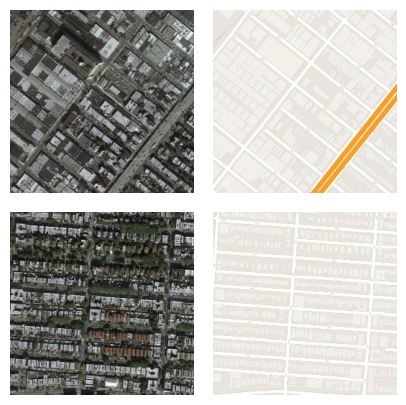

In [39]:
images = next(iter(dataloader_vaild))
left_images, right_images = images
print(left_images.shape)
left_images = denormalize(left_images)
right_images = denormalize(right_images)
show_images(left_images, right_images)

# Architecture

In [40]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Gdyby zmieniać na orginalne pamiętac o dostosowaniu wejściowych kanałów

        # # Layer 1 oryginalnie po  300 filtrów
        # self.conv1_3x3 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        # self.conv1_5x5 = nn.Conv2d(3, 128, kernel_size=5, padding=2)

        # # Layer 2 oryginalnie po 150 filtrów
        # self.conv2_3x3 = nn.Conv2d(256, 64, kernel_size=3, padding=1)
        # self.conv2_5x5 = nn.Conv2d(256, 64, kernel_size=5, padding=2)

        # # Layer 3 oryginalnie po 60 filtrów
        # self.conv3_3x3 = nn.Conv2d(128, 32, kernel_size=3, padding=1)
        # self.conv3_5x5 = nn.Conv2d(128, 32, kernel_size=5, padding=2)

        # # Layer 4 oryginalnie po 20 filtrów
        # self.conv4_3x3 = nn.Conv2d(64, 16, kernel_size=3, padding=1)
        # self.conv4_5x5 = nn.Conv2d(64, 16, kernel_size=5, padding=2)

        # # Layer 5
        # self.trans_conv = nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1)

        # Layer 1 orginalnie po  300 filtrów
        self.conv1_3x3 = nn.Conv2d(3, 300, kernel_size=3, padding=1)
        self.conv1_5x5 = nn.Conv2d(3, 300, kernel_size=5, padding=2)

        # Layer 2 orginalnie po 150 filtrów
        self.conv2_3x3 = nn.Conv2d(600, 150, kernel_size=3, padding=1)
        self.conv2_5x5 = nn.Conv2d(600, 150, kernel_size=5, padding=2)

        # Layer 3 orginalnie po 60 filtrów
        self.conv3_3x3 = nn.Conv2d(300, 60, kernel_size=3, padding=1)
        self.conv3_5x5 = nn.Conv2d(300, 60, kernel_size=5, padding=2)

        # Layer 4 orginalnie po 20 filtrów
        self.conv4_3x3 = nn.Conv2d(120, 20, kernel_size=3, padding=1)
        self.conv4_5x5 = nn.Conv2d(120, 20, kernel_size=5, padding=2)

        # Layer 5
        self.trans_conv = nn.ConvTranspose2d(40, 3, kernel_size=3, padding=1)

    def forward(self, x):
        # Layer 1
        x1_3x3 = self.conv1_3x3(x)
        x1_5x5 = self.conv1_5x5(x)
        x1 = torch.cat((x1_3x3, x1_5x5), dim=1)
        x1 = F.leaky_relu(x1, 0.2)

        # Layer 2
        x2_3x3 = self.conv2_3x3(x1)
        x2_5x5 = self.conv2_5x5(x1)
        x2 = torch.cat((x2_3x3, x2_5x5), dim=1)
        x2 = F.leaky_relu(x2, 0.2)

        # Layer 3
        x3_3x3 = self.conv3_3x3(x2)
        x3_5x5 = self.conv3_5x5(x2)
        x3 = torch.cat((x3_3x3, x3_5x5), dim=1)
        x3 = F.leaky_relu(x3, 0.2)

        # Layer 4
        x4_3x3 = self.conv4_3x3(x3)
        x4_5x5 = self.conv4_5x5(x3)
        x4 = torch.cat((x4_3x3, x4_5x5), dim=1)
        x4 = F.leaky_relu(x4, 0.2)

        # Layer 5
        out = self.trans_conv(x4)
        out = torch.tanh(out)

        return out

In [41]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # # Layer 1
        # self.conv1 = nn.Conv2d(6, 64, kernel_size=3, stride=2, padding=1)

        # # Layer 2
        # self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        # # Layer 3
        # self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        # # Layer 4
        # self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

        # # Layer 5
        # self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1)

        # # Layer 6
        # self.conv6 = nn.Conv2d(1024, 1, kernel_size=4)

        # Layer 1
        self.conv1 = nn.Conv2d(6, 128, kernel_size=3, stride=2, padding=1)

        # Layer 2
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        # Layer 3
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

        # Layer 4
        self.conv4 = nn.Conv2d(512, 768, kernel_size=3, stride=2, padding=1)

        # Layer 5
        self.conv5 = nn.Conv2d(768, 1024, kernel_size=3, stride=2, padding=1)

        # Layer 6
        self.conv6 = nn.Conv2d(1024, 1, kernel_size=4)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)

        # Layer 2
        x = self.conv2(x)
        x = F.leaky_relu(x, 0.2)

        # Layer 3
        x = self.conv3(x)
        x = F.leaky_relu(x, 0.2)

        # Layer 4
        x = self.conv4(x)
        x = F.leaky_relu(x, 0.2)

        # Layer 5
        x = self.conv5(x)
        x = F.leaky_relu(x, 0.2)

        # Layer 6
        x = self.conv6(x)
        x = torch.sigmoid(x)

        return x

# Loss function

In [42]:
def generator_loss(disc_generated_output, gen_output, target):
    gen_gan_loss = F.binary_cross_entropy(disc_generated_output, torch.ones_like(disc_generated_output))
    gen_l1_loss = F.l1_loss(gen_output, target)
    return gen_gan_loss + gen_l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = F.binary_cross_entropy(disc_real_output, torch.ones_like(disc_real_output))
    generated_loss = F.binary_cross_entropy(disc_generated_output, torch.zeros_like(disc_generated_output))
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# Traning

#### We will train models for satelite images to map mapping and for map to satelite images mapping at the same time  

#### Lets prepare now direcoties for generated images savings

In [109]:
!mkdir generated_images; cd generated_images; mkdir map_to_sat; mkdir sat_to_map; cd ..; ls;

generated_images  __MACOSX  maps  maps.zip  sample_data


In [108]:
# !rm -rf generated_images

#### Some utils

In [110]:
def save_generated_images(epoch, left_images, right_images, left_fake, right_fake, base_path="generated_images"):
    map_to_sat_path = os.path.join(base_path, "map_to_sat")
    sat_to_map_path = os.path.join(base_path, "sat_to_map")

    # sat_to_map
    for idx, (left_img, right_img, right_img_fake) in enumerate(zip(left_images, right_images, right_fake)):
        combined_img = torch.cat((left_img.to(torch.float32) / 255.0, right_img.to(torch.float32) / 255.0, right_img_fake.to(torch.float32) / 255.0), dim=2)  # Concatenate along width
        vutils.save_image(combined_img, os.path.join(sat_to_map_path, f"epoch_{epoch}.png"))
        break

    # map_to_sat
    for idx, (right_img, left_img, left_img_fake) in enumerate(zip(right_images, left_images, left_fake)):
        combined_img = torch.cat((right_img.to(torch.float32) / 255.0, left_img.to(torch.float32) / 255.0, left_img_fake.to(torch.float32) / 255.0), dim=2)  # Concatenate along width
        vutils.save_image(combined_img, os.path.join(map_to_sat_path, f"epoch_{epoch}.png"))
        break

In [111]:
def save_models(generator, discriminator, prefix=""):
    torch.save(generator.state_dict(), f'{prefix}geogan_generator.pth')
    torch.save(discriminator.state_dict(), f'{prefix}geogan_discriminatoar.pth')

In [112]:
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

#### Train loop

In [113]:
G_sat_to_map = Generator().to(device)
D_sat_to_map = Discriminator().to(device)
G_sat_to_map_optimizer = torch.optim.Adam(G_sat_to_map.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_sat_to_map_optimizer = torch.optim.Adam(D_sat_to_map.parameters(), lr=0.0002, betas=(0.5, 0.999))

G_map_to_sat = Generator().to(device)
D_map_to_sat = Discriminator().to(device)
G_map_to_sat_optimizer = torch.optim.Adam(G_map_to_sat.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_map_to_sat_optimizer = torch.optim.Adam(D_map_to_sat.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [114]:
epochs = 100
clip_value = 1.0
dataloader_valid_iter = iter(dataloader_vaild)
history = {}

In [ ]:
for epoch in range(epochs):
  G_sat_to_map_loss_acc = 0.0
  D_sat_to_map_loss_acc = 0.0
  G_map_to_sat_loss_acc = 0.0
  D_map_to_sat_loss_acc = 0.0
  G_sat_to_map.train()
  D_sat_to_map.train()
  G_map_to_sat.train()
  D_map_to_sat.train()

  for batch_idx, (left_images, right_images) in enumerate(dataloader_train):
    left_images = left_images.to(device)
    right_images = right_images.to(device)

    right_fake = G_sat_to_map(left_images)
    left_fake = G_map_to_sat(right_images)

    right_fake_detached = right_fake.detach()
    left_fake_detached = left_fake.detach()

    G_sat_to_map_loss = generator_loss(D_sat_to_map(torch.cat((left_images, right_fake), dim=1)), right_fake, right_images)
    G_map_to_sat_loss = generator_loss(D_map_to_sat(torch.cat((right_images, left_fake), dim=1)), left_fake, left_images)

    G_sat_to_map_optimizer.zero_grad()
    G_sat_to_map_loss.backward()
    G_map_to_sat_optimizer.zero_grad()
    G_map_to_sat_loss.backward()

    torch.nn.utils.clip_grad_norm_(G_sat_to_map.parameters(), clip_value)
    torch.nn.utils.clip_grad_norm_(G_map_to_sat.parameters(), clip_value)

    G_sat_to_map_optimizer.step()
    G_map_to_sat_optimizer.step()

    real_sat_to_map = torch.cat((left_images, right_images), dim=1)
    fake_sat_to_map = torch.cat((left_images, right_fake_detached), dim=1)
    D_sat_to_map_loss = discriminator_loss(D_sat_to_map(real_sat_to_map), D_sat_to_map(fake_sat_to_map))
    real_map_to_sat = torch.cat((right_images, left_images), dim=1)
    fake_map_to_sat = torch.cat((right_images, left_fake_detached), dim=1)
    D_map_to_sat_loss = discriminator_loss(D_map_to_sat(real_map_to_sat), D_map_to_sat(fake_map_to_sat))

    D_sat_to_map_optimizer.zero_grad()
    D_sat_to_map_loss.backward()
    D_map_to_sat_optimizer.zero_grad()
    D_map_to_sat_loss.backward()

    torch.nn.utils.clip_grad_norm_(D_sat_to_map.parameters(), clip_value)
    torch.nn.utils.clip_grad_norm_(D_map_to_sat.parameters(), clip_value)

    D_sat_to_map_optimizer.step()
    D_map_to_sat_optimizer.step()

    G_sat_to_map_loss_acc += G_sat_to_map_loss.item() * len(left_images)
    D_sat_to_map_loss_acc += D_sat_to_map_loss.item() * len(left_images)
    G_map_to_sat_loss_acc += G_map_to_sat_loss.item() * len(right_images)
    D_map_to_sat_loss_acc += D_map_to_sat_loss.item() * len(right_images)

    clear_memory()

  # if epoch % 10 == 0:
  if True:
    G_sat_to_map.eval()
    G_map_to_sat.eval()
    with torch.no_grad():
      images = next(dataloader_valid_iter)
      left_images, right_images = images

      right_fake = G_sat_to_map(left_images.to(device))
      left_images = left_images.cpu()
      right_fake = right_fake.cpu()
      left_images = denormalize(left_images)
      right_fake = denormalize(right_fake)
      show_images(
        left_images,
        right_fake,
        title= f"Epoch: {epoch} Generator loss: {G_sat_to_map_loss_acc / len(dataloader_train) :.4f} Discriminator loss: {D_sat_to_map_loss_acc / len(dataloader_train) :.4f}"
        )

      left_fake = G_map_to_sat(right_images.to(device))
      right_images = right_images.cpu()
      left_fake = left_fake.cpu()
      right_images = denormalize(right_images)
      left_fake = denormalize(left_fake)
      show_images(
        right_images,
        left_fake,
        title= f"Epoch: {epoch} Generator loss: {G_map_to_sat_loss_acc / len(dataloader_train) :.4f} Discriminator loss: {D_map_to_sat_loss_acc / len(dataloader_train) :.4f}"
        )

    save_generated_images(epoch, left_images, right_images, left_fake, right_fake)
    history[epoch] = (
        {
            'loss_G_sat_to_map': G_sat_to_map_loss_acc,
            'loss_G_map_to_sat': G_map_to_sat_loss_acc,
            'loss_D_sat_to_map': D_sat_to_map_loss_acc,
            'loss_D_map_to_sat': D_map_to_sat_loss_acc
        },
        {
            'real_map': right_images[0],
            'real_sat': left_images[0],
            'fake_map': right_fake[0],
            'fake_sat': left_fake[0]
        }
    )

In [99]:
torch.cuda.empty_cache()

In [ ]:
save_models(G_sat_to_map, D_sat_to_map, prefix="sat_to_map_")

In [ ]:
save_models(G_map_to_sat, D_map_to_sat, prefix="map_to_sat_")

In [ ]:
with open('history.pkl', 'wb') as pickle_file:
    pickle.dump(history, pickle_file)

print(history)

# Lets see how map generation works

#### Jeszcze nie zmienione (wszsytko)

In [ ]:
def test(G, dataloader):
  G.eval()

  images = next(iter(dataloader_test))
  left_images, right_images = images
  right_fake = G(left_images.to(device))

  left_images = left_images.cpu()
  right_images = right_images.cpu()
  right_fake = right_fake.cpu()

  left_images = denormalize(left_images)
  right_fake = denormalize(right_fake)
  right_images = denormalize(right_images)

  fig, axes = plt.subplots(nrows=3, ncols=left_images.shape[0], figsize=(15, 10))

  for i in range(left_images.shape[0]):
      axes[0, i].imshow(left_images[i].permute(1, 2, 0))
      axes[0, i].axis('off')

      axes[1, i].imshow(right_images[i].permute(1, 2, 0))
      axes[1, i].axis('off')

      axes[2, i].imshow(right_fake[i].permute(1, 2, 0))
      axes[2, i].axis('off')

  plt.show()

256x256

In [ ]:
transform = A.Compose([
    # A.ColorJitter(p=0.3),
    A.Resize(256, 256),
    # A.Rotate(limit=40),
    A.Lambda(image=normalize),
    ToTensorV2(),
], additional_targets={'image0': 'image'})

test_path = 'maps/val'
test_batch_size = 5

dataset_test = ImageFolderDataset(test_path, transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=test_batch_size, shuffle=True)

In [ ]:
test(G, dataloader_test)

512x512

In [ ]:
transform = A.Compose([
    # A.ColorJitter(p=0.3),
    A.Resize(512, 512),
    # A.Rotate(limit=40),
    A.Lambda(image=normalize),
    ToTensorV2(),
], additional_targets={'image0': 'image'})

test_path = 'maps/val'
test_batch_size = 5

dataset_test2 = ImageFolderDataset(test_path, transform=transform)
dataloader_test2 = DataLoader(dataset_test2, batch_size=test_batch_size, shuffle=True)

In [ ]:
test(G, dataloader_test2)